In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from collections import Counter

In [2]:
# import cleaned data
df = pd.read_csv('data_cleaned.csv')

In [3]:
clusteringDf = df[['Entity', 'Daily tests', 'Daily cases', 'Daily deaths']].groupby('Entity').sum().reset_index()
clusteringDf['Population'] = df[['Entity', 'Population']].groupby('Entity')['Population'].first().reset_index().drop_duplicates('Entity')['Population']

clusteringDf.rename(columns={'Daily tests': 'Total tests', 'Daily cases': 'Total cases', 'Daily deaths': 'Total deaths'}, inplace=True)

clusteringDf['positivity_rate'] = (clusteringDf['Total cases'] / clusteringDf['Total tests']) * 100
clusteringDf['death_rate'] = (clusteringDf['Total deaths'] / clusteringDf['Total cases']) * 100
clusteringDf['mortality_rate'] = (clusteringDf['Total cases'] / clusteringDf['Population']) * 100
clusteringDf

,Entity,Total tests,Total cases,Total deaths,Population,positivity_rate,death_rate,mortality_rate
0,Albania,432998.0,104313,1736,2873457,24.090873,1.664222,3.630227
1,Argentina,6088924.0,2049936,51014,44271041,33.666638,2.488565,4.630422
2,Australia,9336541.0,23160,869,24598933,0.248058,3.752159,0.094150
3,Austria,14269635.0,441638,8335,8809212,3.094950,1.887292,5.013366
4,Bahrain,2572783.0,121017,442,1492584,4.703739,0.365238,8.107885
...,...,...,...,...,...,...,...,...
94,United Kingdom,83348027.0,4117892,119522,66022273,4.940599,2.902504,6.237125
95,United States,328405054.0,28261563,502678,325719178,8.605703,1.778663,8.676665
96,Uruguay,804508.0,53001,582,3456750,6.588002,1.098092,1.533261
97,Zambia,1043457.0,76722,999,17094130,7.352675,1.302104,0.448821


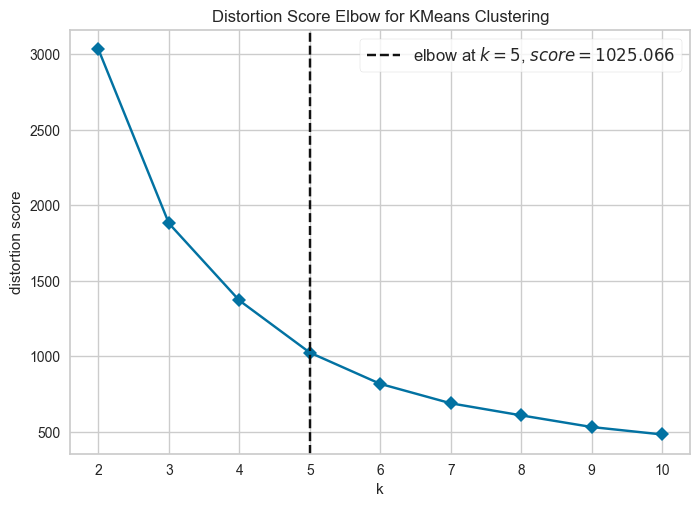

<AxesSubplot: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [15]:
from yellowbrick.cluster import KElbowVisualizer
kmeans = KMeans(n_init=10)
sil_vis = KElbowVisualizer(kmeans, timings=False)
sil_vis.fit(clusteringDf[['positivity_rate', 'death_rate', 'mortality_rate']])
sil_vis.show()

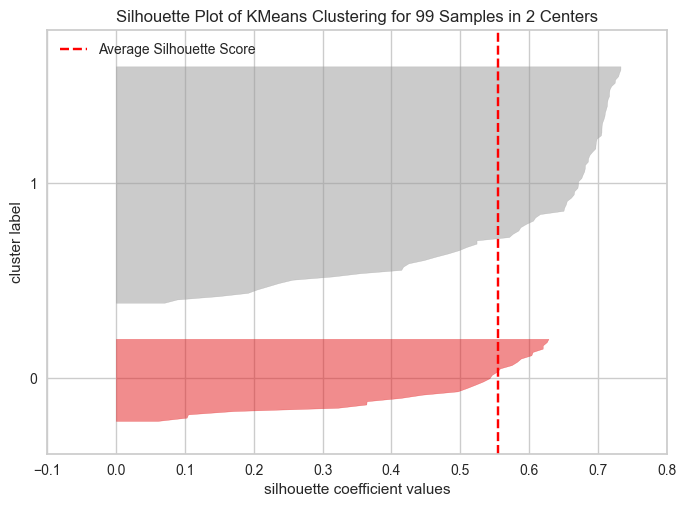

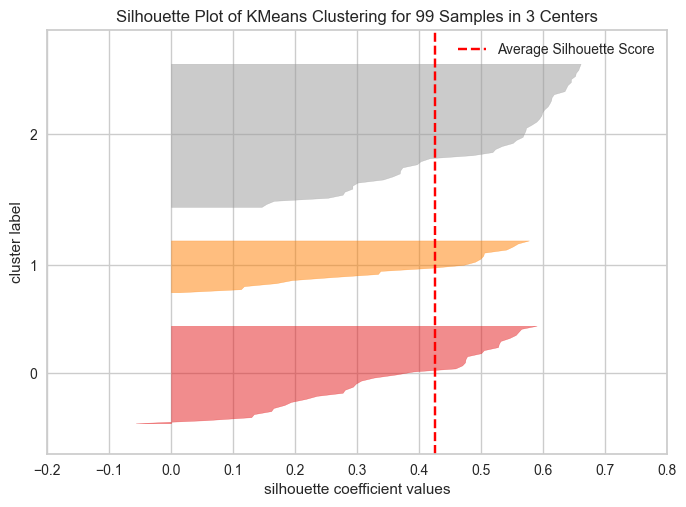

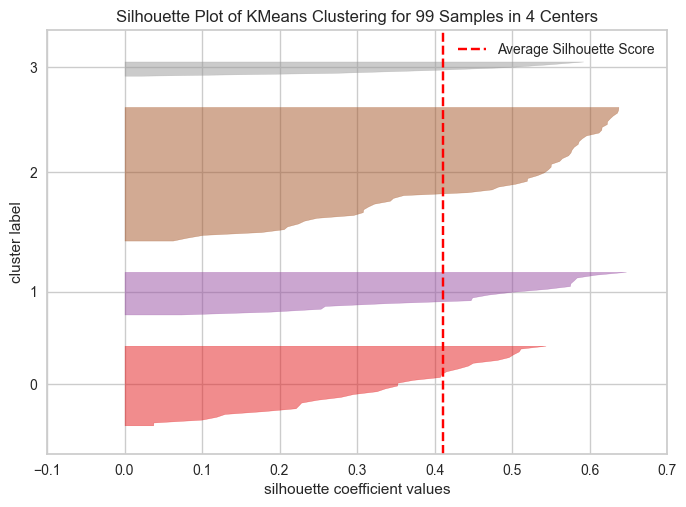

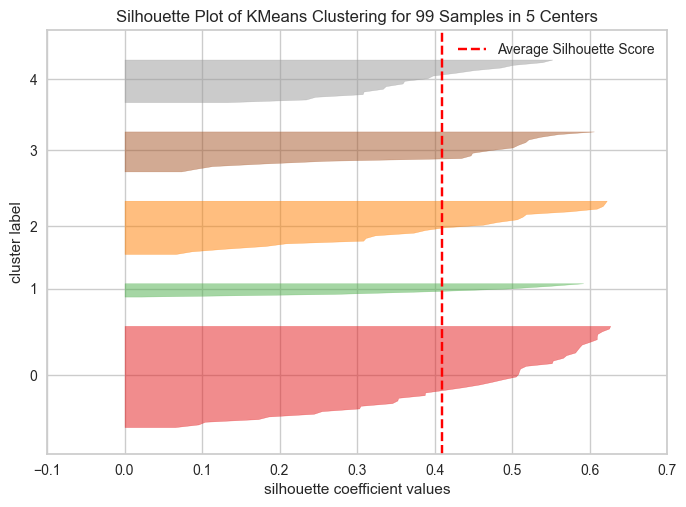

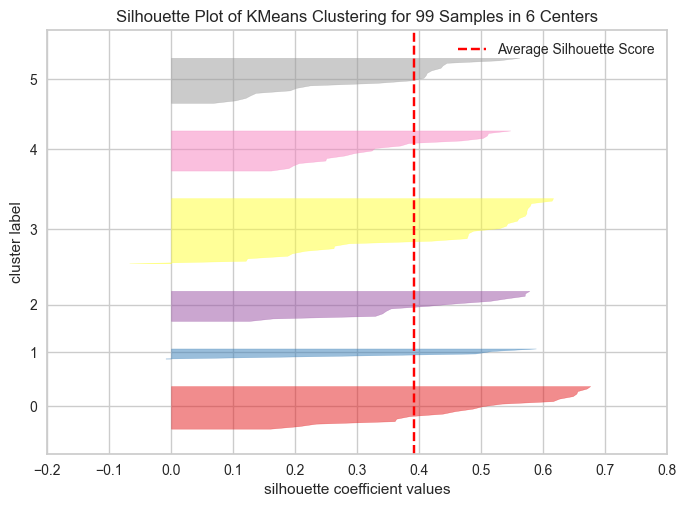

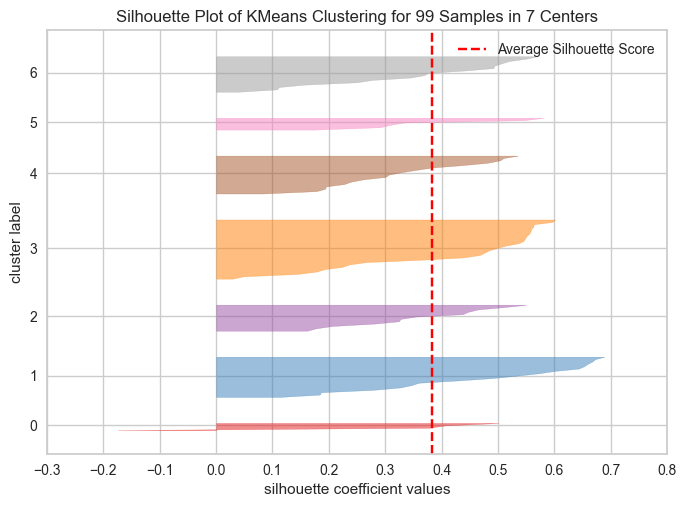

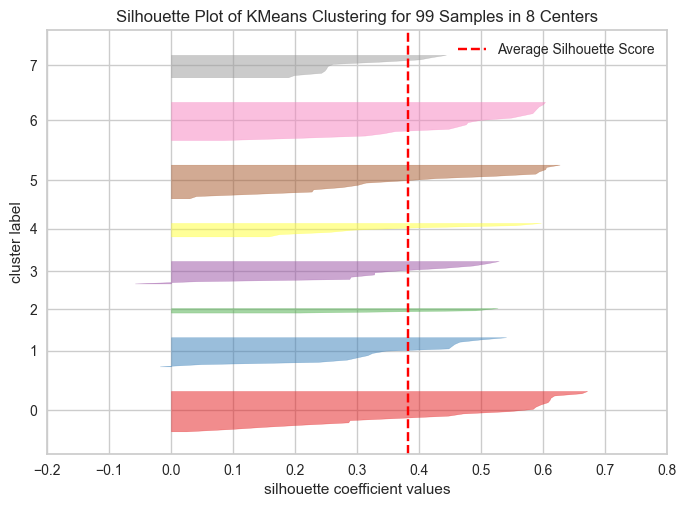

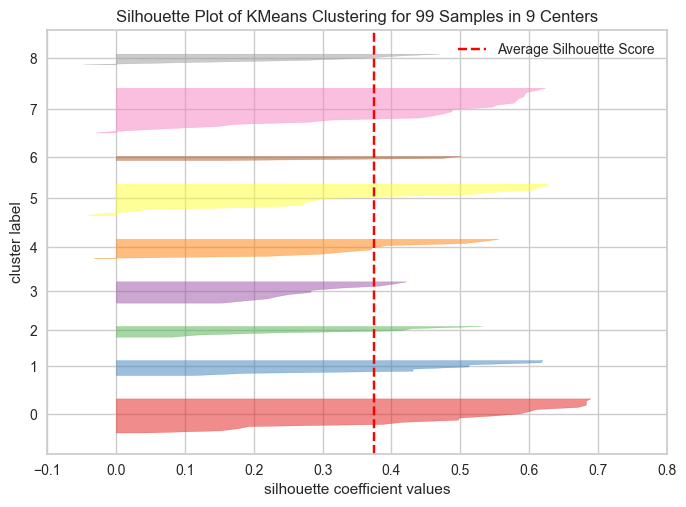

In [18]:
from yellowbrick.cluster import  SilhouetteVisualizer

for k in range(2,10):
    kmeans = KMeans(n_clusters=k,n_init=10)
    sil_vis = SilhouetteVisualizer(kmeans)
    sil_vis.fit(clusteringDf[['positivity_rate', 'death_rate', 'mortality_rate']])
    sil_vis.show()

In [19]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
resultDf = clusteringDf[['positivity_rate', 'death_rate', 'mortality_rate']]
resultDf.to_csv('clustering.csv', index=False)

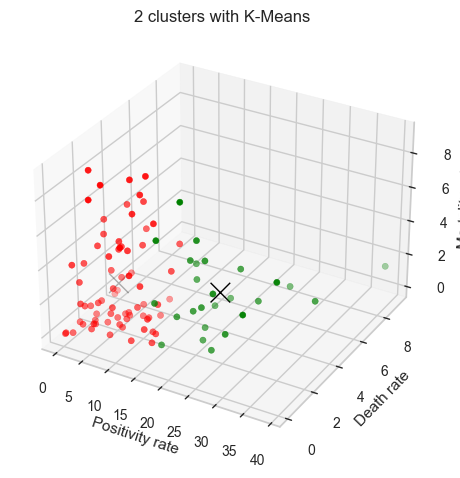

cluster 1 with: 73 entities (red)


,Latitude,Longitude,Average temperature per year,Hospital beds per 1000 people,Medical doctors per 1000 people,GDP/Capita,Population,Median age,Population aged 65 and over (%),"(Daily tests, min)","(Daily tests, max)","(Daily tests, mean)","(Daily cases, min)","(Daily cases, max)","(Daily cases, mean)","(Daily deaths, min)","(Daily deaths, max)","(Daily deaths, mean)",positivity_rate,death_rate,mortality_rate
Entity,,,,,,,,,,,,,,,,,,,,,
Australia,-25.27,133.78,22.0,3.84,3.50,55060.3,2.459893e+07,37.0,16.0,4357.0,101274.0,41312.128319,0.0,1600.0,102.477876,0.0,74.0,3.845133,0.248058,3.752159,0.094150
Austria,47.52,14.55,8.0,7.37,5.23,50137.7,8.809212e+06,44.0,19.0,2376.0,2945871.0,43504.984756,0.0,9586.0,1346.457317,0.0,218.0,25.411585,3.094950,1.887292,5.013366
Bahrain,25.93,50.64,27.0,2.00,0.92,23504.0,1.492584e+06,32.0,2.0,232.0,23177.0,9254.615108,0.0,5114.0,435.312950,0.0,24.0,1.589928,4.703739,0.365238,8.107885
Bangladesh,23.68,90.36,25.0,0.80,0.47,1855.7,1.646698e+08,27.0,5.0,3.0,19054.0,11174.041899,0.0,4019.0,1522.217877,0.0,64.0,23.418994,13.622804,1.538478,0.330938
Belgium,50.50,4.47,10.0,5.64,3.01,46420.7,1.137207e+07,41.0,19.0,82.0,80815.0,25879.390582,0.0,23921.0,2107.498615,0.0,496.0,60.908587,8.143540,2.890089,6.690138
Bhutan,27.51,90.43,13.0,1.70,0.38,3316.2,8.076100e+05,28.0,6.0,2.0,15058.0,1587.459375,0.0,57.0,2.512500,0.0,1.0,0.003125,0.158272,0.124378,0.099553
Canada,56.13,-106.35,-1.0,2.50,2.54,46194.7,3.670808e+07,41.0,17.0,2568.0,255537.0,54156.436137,0.0,16141.0,2425.183801,0.0,244.0,62.102804,4.478108,2.560746,2.120743
Chile,-35.68,-71.54,9.0,2.11,1.03,14896.5,1.805473e+07,35.0,12.0,2759.0,68458.0,28369.472050,0.0,13990.0,2502.015528,0.0,1057.0,62.872671,8.819394,2.512881,4.462261
Cuba,21.52,-77.78,26.0,5.20,7.52,8821.8,1.148464e+07,43.0,15.0,107.0,19710.0,6893.926254,0.0,1044.0,138.218289,0.0,6.0,0.905605,2.004928,0.655199,0.407989


cluster 1 with: 73 entities (red)


,Latitude,Longitude,Average temperature per year,Hospital beds per 1000 people,Medical doctors per 1000 people,GDP/Capita,Population,Median age,Population aged 65 and over (%),"(Daily tests, min)","(Daily tests, max)","(Daily tests, mean)","(Daily cases, min)","(Daily cases, max)","(Daily cases, mean)","(Daily deaths, min)","(Daily deaths, max)","(Daily deaths, mean)",positivity_rate,death_rate,mortality_rate
min,-40.90000,-106.350000,-2.000000,0.300000,0.020000,411.600000,3.412840e+05,16.000000,1.000000,1.0,6.370000e+02,90.672862,0.0,5.000000,0.208178,0.0,1.000000,0.003125,0.150289,0.082679,0.006184
mean,26.18589,31.179726,16.917808,3.199863,2.216712,23499.182192,5.060201e+07,33.150685,11.136986,920.0,1.778357e+05,46527.809132,0.0,15602.890411,2879.468315,0.0,315.821918,53.475156,6.424538,1.652747,2.581386
max,64.96000,179.410000,29.000000,13.050000,7.520000,114704.600000,1.339180e+09,48.000000,28.000000,11896.0,2.945871e+06,912236.261111,0.0,299786.000000,78504.341667,0.0,4398.000000,1396.327778,14.127421,4.084622,9.100024


cluster 2 with: 26 entities (green)


,Latitude,Longitude,Average temperature per year,Hospital beds per 1000 people,Medical doctors per 1000 people,GDP/Capita,Population,Median age,Population aged 65 and over (%),"(Daily tests, min)","(Daily tests, max)","(Daily tests, mean)","(Daily cases, min)","(Daily cases, max)","(Daily cases, mean)","(Daily deaths, min)","(Daily deaths, max)","(Daily deaths, mean)",positivity_rate,death_rate,mortality_rate
Entity,,,,,,,,,,,,,,,,,,,,,
Albania,41.15,20.17,14.0,2.89,1.29,5353.2,2873457.0,38.0,14.0,1.0,4562.0,1192.831956,0.0,2077.0,287.363636,0.0,27.0,4.782369,24.090873,1.664222,3.630227
Argentina,-38.42,-63.62,14.0,5.00,3.91,9912.3,44271041.0,31.0,11.0,1.0,48659.0,15414.997468,0.0,18326.0,5189.711392,0.0,3351.0,129.149367,33.666638,2.488565,4.630422
Bolivia,-16.29,-63.59,20.0,1.10,0.47,3552.1,11051600.0,25.0,7.0,1.0,9377.0,2153.768987,0.0,2866.0,769.468354,0.0,1656.0,35.750000,35.726596,4.646065,2.200152
Bosnia and Herzegovina,43.92,17.68,12.0,3.50,1.89,6108.5,3507017.0,42.0,16.0,402.0,9431.0,2134.802469,0.0,2544.0,508.522634,0.0,86.0,19.629630,23.820594,3.860129,3.523536
Bulgaria,42.73,25.49,13.0,7.45,4.00,9828.1,7075991.0,44.0,21.0,295.0,15651.0,5632.987952,0.0,5951.0,874.931727,0.0,292.0,33.606426,15.532285,3.841034,3.078834
Cape Verde,16.00,-24.01,24.0,2.10,0.79,3603.8,546388.0,25.0,5.0,50.0,980.0,397.805668,0.0,309.0,59.825911,0.0,4.0,0.574899,15.038979,0.960953,2.704488
Colombia,4.57,-74.30,25.0,1.71,1.82,6428.7,49065615.0,32.0,8.0,10885.0,93133.0,41124.195489,0.0,21078.0,8300.266917,0.0,400.0,219.364662,20.183415,2.642863,4.499834
Costa Rica,9.75,-83.75,26.0,1.13,1.15,12243.8,4905769.0,33.0,10.0,1.0,4648.0,1597.744745,0.0,1665.0,487.042042,0.0,33.0,6.195195,30.483095,1.272004,3.306006
Croatia,45.10,15.20,13.0,5.54,3.13,14936.1,4125700.0,44.0,20.0,8.0,12596.0,3746.563636,0.0,7088.0,733.596970,0.0,305.0,16.675758,19.580529,2.273150,5.867780


cluster 2 with: 26 entities (green)


,Latitude,Longitude,Average temperature per year,Hospital beds per 1000 people,Medical doctors per 1000 people,GDP/Capita,Population,Median age,Population aged 65 and over (%),"(Daily tests, min)","(Daily tests, max)","(Daily tests, mean)","(Daily cases, min)","(Daily cases, max)","(Daily cases, mean)","(Daily deaths, min)","(Daily deaths, max)","(Daily deaths, mean)",positivity_rate,death_rate,mortality_rate
min,-38.420000,-102.550000,9.0,0.200000,0.070000,523.400000,5.463880e+05,18.000000,3.000000,1.000000,980.000000,329.213115,0.0,309.000000,59.825911,0.0,4.000000,0.574899,15.038979,0.960953,0.019792
mean,13.992308,-17.783462,20.0,2.745769,1.603462,7065.038462,4.088151e+07,30.807692,9.307692,1227.115385,41023.076923,9717.823674,0.0,11714.807692,2090.047715,0.0,840.269231,71.518743,22.463650,2.871715,2.697007
max,51.920000,113.920000,29.0,8.800000,4.000000,15731.000000,2.639914e+08,44.000000,21.000000,10885.000000,327863.000000,41124.195489,0.0,38890.000000,8300.266917,0.0,3887.000000,431.172152,38.817336,9.150768,8.280463


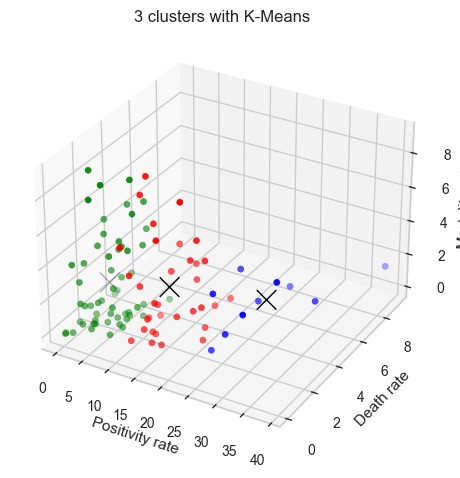

cluster 1 with: 33 entities (red)


,Latitude,Longitude,Average temperature per year,Hospital beds per 1000 people,Medical doctors per 1000 people,GDP/Capita,Population,Median age,Population aged 65 and over (%),"(Daily tests, min)","(Daily tests, max)","(Daily tests, mean)","(Daily cases, min)","(Daily cases, max)","(Daily cases, mean)","(Daily deaths, min)","(Daily deaths, max)","(Daily deaths, mean)",positivity_rate,death_rate,mortality_rate
Entity,,,,,,,,,,,,,,,,,,,,,
Bangladesh,23.68,90.36,25.0,0.80,0.47,1855.7,164669751.0,27.0,5.0,3.0,19054.0,11174.041899,0.0,4019.0,1522.217877,0.0,64.0,23.418994,13.622804,1.538478,0.330938
Bulgaria,42.73,25.49,13.0,7.45,4.00,9828.1,7075991.0,44.0,21.0,295.0,15651.0,5632.987952,0.0,5951.0,874.931727,0.0,292.0,33.606426,15.532285,3.841034,3.078834
Cape Verde,16.00,-24.01,24.0,2.10,0.79,3603.8,546388.0,25.0,5.0,50.0,980.0,397.805668,0.0,309.0,59.825911,0.0,4.0,0.574899,15.038979,0.960953,2.704488
Colombia,4.57,-74.30,25.0,1.71,1.82,6428.7,49065615.0,32.0,8.0,10885.0,93133.0,41124.195489,0.0,21078.0,8300.266917,0.0,400.0,219.364662,20.183415,2.642863,4.499834
Croatia,45.10,15.20,13.0,5.54,3.13,14936.1,4125700.0,44.0,20.0,8.0,12596.0,3746.563636,0.0,7088.0,733.596970,0.0,305.0,16.675758,19.580529,2.273150,5.867780
Ghana,7.95,-1.02,27.0,0.90,0.10,2202.1,28833629.0,21.0,3.0,206.0,12735.0,2682.280899,0.0,2020.0,298.232210,0.0,28.0,2.134831,11.118605,0.715829,0.276164
Guatemala,15.78,-90.23,24.0,0.60,0.90,4620.0,16913503.0,22.0,5.0,1.0,8054.0,2437.418539,0.0,1739.0,469.932584,0.0,61.0,17.587079,19.279930,3.742468,0.989127
Hungary,47.16,19.50,12.0,7.02,3.09,16731.8,9781127.0,43.0,19.0,39.0,32067.0,8842.595506,0.0,6819.0,1159.227528,0.0,193.0,41.297753,13.109584,3.562523,4.219197
Indonesia,-0.79,113.92,26.0,1.04,0.20,4135.6,263991379.0,29.0,6.0,25.0,87194.0,21015.600746,0.0,37526.0,4164.462687,0.0,823.0,115.503731,19.816053,2.773557,0.422770


cluster 1 with: 33 entities (red)


,Latitude,Longitude,Average temperature per year,Hospital beds per 1000 people,Medical doctors per 1000 people,GDP/Capita,Population,Median age,Population aged 65 and over (%),"(Daily tests, min)","(Daily tests, max)","(Daily tests, mean)","(Daily cases, min)","(Daily cases, max)","(Daily cases, mean)","(Daily deaths, min)","(Daily deaths, max)","(Daily deaths, mean)",positivity_rate,death_rate,mortality_rate
min,-30.560000,-90.230000,8.000000,0.200000,0.020000,411.600000,5.463880e+05,17.000000,1.000000,1.000000,980.000000,308.108108,0.0,257.000000,32.416216,0.0,4.000000,0.574899,9.836193,0.159684,0.019792
mean,19.348485,15.395152,19.878788,2.830909,1.660909,12034.693939,3.740423e+07,30.484848,8.969697,1342.060606,40402.666667,10457.017320,0.0,10873.212121,1685.322293,0.0,274.272727,42.240192,15.098235,2.027002,2.914646
max,51.920000,113.920000,28.000000,8.800000,4.430000,81993.700000,2.639914e+08,46.000000,22.000000,10885.000000,327863.000000,41124.195489,0.0,38890.000000,8300.266917,0.0,1489.000000,252.118343,21.087159,4.267068,8.911101


cluster 2 with: 56 entities (green)


,Latitude,Longitude,Average temperature per year,Hospital beds per 1000 people,Medical doctors per 1000 people,GDP/Capita,Population,Median age,Population aged 65 and over (%),"(Daily tests, min)","(Daily tests, max)","(Daily tests, mean)","(Daily cases, min)","(Daily cases, max)","(Daily cases, mean)","(Daily deaths, min)","(Daily deaths, max)","(Daily deaths, mean)",positivity_rate,death_rate,mortality_rate
Entity,,,,,,,,,,,,,,,,,,,,,
Australia,-25.27,133.78,22.0,3.84,3.50,55060.3,2.459893e+07,37.0,16.0,4357.0,101274.0,41312.128319,0.0,1600.0,102.477876,0.0,74.0,3.845133,0.248058,3.752159,0.094150
Austria,47.52,14.55,8.0,7.37,5.23,50137.7,8.809212e+06,44.0,19.0,2376.0,2945871.0,43504.984756,0.0,9586.0,1346.457317,0.0,218.0,25.411585,3.094950,1.887292,5.013366
Bahrain,25.93,50.64,27.0,2.00,0.92,23504.0,1.492584e+06,32.0,2.0,232.0,23177.0,9254.615108,0.0,5114.0,435.312950,0.0,24.0,1.589928,4.703739,0.365238,8.107885
Belgium,50.50,4.47,10.0,5.64,3.01,46420.7,1.137207e+07,41.0,19.0,82.0,80815.0,25879.390582,0.0,23921.0,2107.498615,0.0,496.0,60.908587,8.143540,2.890089,6.690138
Bhutan,27.51,90.43,13.0,1.70,0.38,3316.2,8.076100e+05,28.0,6.0,2.0,15058.0,1587.459375,0.0,57.0,2.512500,0.0,1.0,0.003125,0.158272,0.124378,0.099553
Canada,56.13,-106.35,-1.0,2.50,2.54,46194.7,3.670808e+07,41.0,17.0,2568.0,255537.0,54156.436137,0.0,16141.0,2425.183801,0.0,244.0,62.102804,4.478108,2.560746,2.120743
Chile,-35.68,-71.54,9.0,2.11,1.03,14896.5,1.805473e+07,35.0,12.0,2759.0,68458.0,28369.472050,0.0,13990.0,2502.015528,0.0,1057.0,62.872671,8.819394,2.512881,4.462261
Cuba,21.52,-77.78,26.0,5.20,7.52,8821.8,1.148464e+07,43.0,15.0,107.0,19710.0,6893.926254,0.0,1044.0,138.218289,0.0,6.0,0.905605,2.004928,0.655199,0.407989
Cyprus,35.13,33.43,20.0,3.40,2.50,27858.4,1.179551e+06,37.0,14.0,400.0,40974.0,6479.961078,0.0,907.0,100.883234,0.0,8.0,0.676647,1.556849,0.670723,2.856595


cluster 2 with: 56 entities (green)


,Latitude,Longitude,Average temperature per year,Hospital beds per 1000 people,Medical doctors per 1000 people,GDP/Capita,Population,Median age,Population aged 65 and over (%),"(Daily tests, min)","(Daily tests, max)","(Daily tests, mean)","(Daily cases, min)","(Daily cases, max)","(Daily cases, mean)","(Daily deaths, min)","(Daily deaths, max)","(Daily deaths, mean)",positivity_rate,death_rate,mortality_rate
min,-40.900000,-106.350000,-2.000000,0.300000,0.0200,679.300000,3.412840e+05,16.000000,1.000000,1.000000,6.370000e+02,90.672862,0.0,5.000000,0.208178,0.0,1.000000,0.003125,0.150289,0.082679,0.006184
mean,27.578571,32.422679,15.982143,3.418929,2.3825,25566.919643,5.826386e+07,34.160714,11.946429,965.589286,2.237989e+05,58115.065559,0.0,17951.821429,3444.469533,0.0,354.017857,64.069390,4.695507,1.646101,2.474211
max,64.960000,179.410000,29.000000,13.050000,7.5200,114704.600000,1.339180e+09,48.000000,28.000000,11896.000000,2.945871e+06,912236.261111,0.0,299786.000000,78504.341667,0.0,4398.000000,1396.327778,9.667089,4.084622,9.100024


cluster 3 with: 10 entities (blue)


,Latitude,Longitude,Average temperature per year,Hospital beds per 1000 people,Medical doctors per 1000 people,GDP/Capita,Population,Median age,Population aged 65 and over (%),"(Daily tests, min)","(Daily tests, max)","(Daily tests, mean)","(Daily cases, min)","(Daily cases, max)","(Daily cases, mean)","(Daily deaths, min)","(Daily deaths, max)","(Daily deaths, mean)",positivity_rate,death_rate,mortality_rate
Entity,,,,,,,,,,,,,,,,,,,,,
Albania,41.15,20.17,14.0,2.89,1.29,5353.2,2873457.0,38.0,14.0,1.0,4562.0,1192.831956,0.0,2077.0,287.363636,0.0,27.0,4.782369,24.090873,1.664222,3.630227
Argentina,-38.42,-63.62,14.0,5.00,3.91,9912.3,44271041.0,31.0,11.0,1.0,48659.0,15414.997468,0.0,18326.0,5189.711392,0.0,3351.0,129.149367,33.666638,2.488565,4.630422
Bolivia,-16.29,-63.59,20.0,1.10,0.47,3552.1,11051600.0,25.0,7.0,1.0,9377.0,2153.768987,0.0,2866.0,769.468354,0.0,1656.0,35.750000,35.726596,4.646065,2.200152
Bosnia and Herzegovina,43.92,17.68,12.0,3.50,1.89,6108.5,3507017.0,42.0,16.0,402.0,9431.0,2134.802469,0.0,2544.0,508.522634,0.0,86.0,19.629630,23.820594,3.860129,3.523536
Costa Rica,9.75,-83.75,26.0,1.13,1.15,12243.8,4905769.0,33.0,10.0,1.0,4648.0,1597.744745,0.0,1665.0,487.042042,0.0,33.0,6.195195,30.483095,1.272004,3.306006
Dominican Republic,18.74,-70.16,26.0,1.60,1.49,8282.1,10766998.0,27.0,7.0,134.0,8674.0,2841.394366,0.0,5098.0,748.023474,0.0,67.0,12.446009,26.325929,1.663853,1.479790
Ecuador,-1.83,-78.18,22.0,1.50,1.66,6183.8,16624858.0,28.0,7.0,64.0,12181.0,2778.088415,0.0,3942.0,789.887195,0.0,3852.0,45.945122,28.432759,5.816669,1.558407
Mauritania,21.01,-10.94,29.0,0.40,0.07,1679.4,4420184.0,20.0,3.0,1.0,1068.0,329.213115,0.0,542.0,76.819672,0.0,17.0,1.409836,23.334329,1.835254,0.106014
Mexico,23.63,-102.55,22.0,1.38,2.23,9946.0,129163276.0,29.0,7.0,25.0,46498.0,12138.567089,0.0,26626.0,4711.868354,0.0,3050.0,431.172152,38.817336,9.150768,1.440958


cluster 3 with: 10 entities (blue)


,Latitude,Longitude,Average temperature per year,Hospital beds per 1000 people,Medical doctors per 1000 people,GDP/Capita,Population,Median age,Population aged 65 and over (%),"(Daily tests, min)","(Daily tests, max)","(Daily tests, mean)","(Daily cases, min)","(Daily cases, max)","(Daily cases, mean)","(Daily deaths, min)","(Daily deaths, max)","(Daily deaths, mean)",positivity_rate,death_rate,mortality_rate
min,-38.420,-102.550,12.0,0.40,0.070,1679.40,2873457.0,20.0,3.0,1.0,1068.0,329.213115,0.0,542.0,76.819672,0.0,17.0,1.409836,23.334329,1.272004,0.106014
mean,9.247,-50.996,20.4,2.01,1.528,7023.89,25974968.5,30.2,9.0,70.4,18257.6,4966.823932,0.0,7947.8,1603.649809,0.0,1602.6,78.136157,29.185604,3.624234,2.382424
max,43.920,20.170,29.0,5.00,3.910,12243.80,129163276.0,42.0,16.0,402.0,48659.0,15414.997468,0.0,26626.0,5189.711392,0.0,3887.0,431.172152,38.817336,9.150768,4.630422


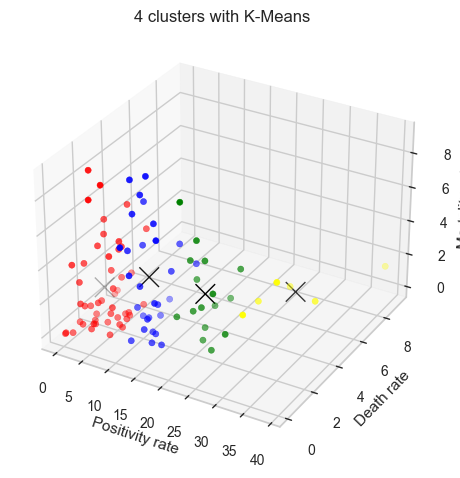

cluster 1 with: 48 entities (red)


,Latitude,Longitude,Average temperature per year,Hospital beds per 1000 people,Medical doctors per 1000 people,GDP/Capita,Population,Median age,Population aged 65 and over (%),"(Daily tests, min)","(Daily tests, max)","(Daily tests, mean)","(Daily cases, min)","(Daily cases, max)","(Daily cases, mean)","(Daily deaths, min)","(Daily deaths, max)","(Daily deaths, mean)",positivity_rate,death_rate,mortality_rate
Entity,,,,,,,,,,,,,,,,,,,,,
Australia,-25.27,133.78,22.0,3.84,3.50,55060.3,2.459893e+07,37.0,16.0,4357.0,101274.0,41312.128319,0.0,1600.0,102.477876,0.0,74.0,3.845133,0.248058,3.752159,0.094150
Austria,47.52,14.55,8.0,7.37,5.23,50137.7,8.809212e+06,44.0,19.0,2376.0,2945871.0,43504.984756,0.0,9586.0,1346.457317,0.0,218.0,25.411585,3.094950,1.887292,5.013366
Bahrain,25.93,50.64,27.0,2.00,0.92,23504.0,1.492584e+06,32.0,2.0,232.0,23177.0,9254.615108,0.0,5114.0,435.312950,0.0,24.0,1.589928,4.703739,0.365238,8.107885
Bhutan,27.51,90.43,13.0,1.70,0.38,3316.2,8.076100e+05,28.0,6.0,2.0,15058.0,1587.459375,0.0,57.0,2.512500,0.0,1.0,0.003125,0.158272,0.124378,0.099553
Canada,56.13,-106.35,-1.0,2.50,2.54,46194.7,3.670808e+07,41.0,17.0,2568.0,255537.0,54156.436137,0.0,16141.0,2425.183801,0.0,244.0,62.102804,4.478108,2.560746,2.120743
Cuba,21.52,-77.78,26.0,5.20,7.52,8821.8,1.148464e+07,43.0,15.0,107.0,19710.0,6893.926254,0.0,1044.0,138.218289,0.0,6.0,0.905605,2.004928,0.655199,0.407989
Cyprus,35.13,33.43,20.0,3.40,2.50,27858.4,1.179551e+06,37.0,14.0,400.0,40974.0,6479.961078,0.0,907.0,100.883234,0.0,8.0,0.676647,1.556849,0.670723,2.856595
Denmark,56.26,9.50,8.0,2.50,3.66,60170.3,5.769603e+06,42.0,20.0,1.0,166497.0,43638.315508,0.0,4508.0,562.486631,0.0,60.0,6.288770,1.288974,1.118030,3.646178
El Salvador,13.79,-88.90,25.0,1.30,1.60,4187.3,6.377853e+06,27.0,8.0,457.0,5498.0,2321.788732,0.0,2015.0,183.061033,0.0,49.0,5.201878,7.884483,2.841609,0.611366


cluster 1 with: 48 entities (red)


,Latitude,Longitude,Average temperature per year,Hospital beds per 1000 people,Medical doctors per 1000 people,GDP/Capita,Population,Median age,Population aged 65 and over (%),"(Daily tests, min)","(Daily tests, max)","(Daily tests, mean)","(Daily cases, min)","(Daily cases, max)","(Daily cases, mean)","(Daily deaths, min)","(Daily deaths, max)","(Daily deaths, mean)",positivity_rate,death_rate,mortality_rate
min,-40.900000,-106.350000,-2.000,0.300000,0.020000,679.3000,3.412840e+05,16.000000,1.000000,1.000000,6.370000e+02,90.672862,0.0,5.000000,0.208178,0.0,1.000000,0.003125,0.150289,0.082679,0.006184
mean,28.123333,40.173333,16.375,3.522083,2.447292,25579.1875,5.888781e+07,34.354167,11.854167,901.479167,2.093822e+05,46673.751633,0.0,13159.895833,2195.780719,0.0,273.791667,41.575533,3.984670,1.532814,2.190903
max,64.960000,179.410000,29.000,13.050000,7.520000,114704.6000,1.339180e+09,48.000000,28.000000,11896.000000,2.945871e+06,639512.728125,0.0,108201.000000,34142.237500,0.0,3410.000000,486.903125,7.884483,3.752159,9.100024


cluster 2 with: 16 entities (green)


,Latitude,Longitude,Average temperature per year,Hospital beds per 1000 people,Medical doctors per 1000 people,GDP/Capita,Population,Median age,Population aged 65 and over (%),"(Daily tests, min)","(Daily tests, max)","(Daily tests, mean)","(Daily cases, min)","(Daily cases, max)","(Daily cases, mean)","(Daily deaths, min)","(Daily deaths, max)","(Daily deaths, mean)",positivity_rate,death_rate,mortality_rate
Entity,,,,,,,,,,,,,,,,,,,,,
Albania,41.15,20.17,14.0,2.89,1.29,5353.2,2873457.0,38.0,14.0,1.0,4562.0,1192.831956,0.0,2077.0,287.363636,0.0,27.0,4.782369,24.090873,1.664222,3.630227
Bosnia and Herzegovina,43.92,17.68,12.0,3.50,1.89,6108.5,3507017.0,42.0,16.0,402.0,9431.0,2134.802469,0.0,2544.0,508.522634,0.0,86.0,19.629630,23.820594,3.860129,3.523536
Colombia,4.57,-74.30,25.0,1.71,1.82,6428.7,49065615.0,32.0,8.0,10885.0,93133.0,41124.195489,0.0,21078.0,8300.266917,0.0,400.0,219.364662,20.183415,2.642863,4.499834
Croatia,45.10,15.20,13.0,5.54,3.13,14936.1,4125700.0,44.0,20.0,8.0,12596.0,3746.563636,0.0,7088.0,733.596970,0.0,305.0,16.675758,19.580529,2.273150,5.867780
Dominican Republic,18.74,-70.16,26.0,1.60,1.49,8282.1,10766998.0,27.0,7.0,134.0,8674.0,2841.394366,0.0,5098.0,748.023474,0.0,67.0,12.446009,26.325929,1.663853,1.479790
Guatemala,15.78,-90.23,24.0,0.60,0.90,4620.0,16913503.0,22.0,5.0,1.0,8054.0,2437.418539,0.0,1739.0,469.932584,0.0,61.0,17.587079,19.279930,3.742468,0.989127
Indonesia,-0.79,113.92,26.0,1.04,0.20,4135.6,263991379.0,29.0,6.0,25.0,87194.0,21015.600746,0.0,37526.0,4164.462687,0.0,823.0,115.503731,19.816053,2.773557,0.422770
Iran,32.43,53.69,20.0,1.50,1.49,5550.1,81162788.0,32.0,6.0,9135.0,92186.0,28202.165680,0.0,38890.0,5908.467456,0.0,1489.0,252.118343,20.950403,4.267068,1.230282
Libya,26.34,17.23,24.0,3.70,2.09,7685.9,6374616.0,29.0,4.0,1.0,7698.0,2074.682143,0.0,1698.0,356.446429,0.0,48.0,6.160714,17.180773,1.728370,1.565663


cluster 2 with: 16 entities (green)


,Latitude,Longitude,Average temperature per year,Hospital beds per 1000 people,Medical doctors per 1000 people,GDP/Capita,Population,Median age,Population aged 65 and over (%),"(Daily tests, min)","(Daily tests, max)","(Daily tests, mean)","(Daily cases, min)","(Daily cases, max)","(Daily cases, mean)","(Daily deaths, min)","(Daily deaths, max)","(Daily deaths, mean)",positivity_rate,death_rate,mortality_rate
min,-30.56,-90.230000,9.0,0.20000,0.07000,523.40000,2873457.0,19.000,3.0000,1.0000,984.0000,329.213115,0.0,429.0,76.819672,0.0,10.0000,1.409836,17.012790,1.663853,0.019792
mean,17.77,-1.676875,20.0,2.75125,1.46875,6987.60625,38700387.0,31.125,9.0625,1930.5625,52418.0625,11944.292555,0.0,13521.0,2317.667776,0.0,350.6875,66.350085,20.519757,2.525135,2.677685
max,51.92,113.920000,29.0,8.80000,3.13000,15731.00000,263991379.0,44.000,20.0000,10885.0000,327863.0000,41124.195489,0.0,38890.0,8300.266917,0.0,1489.0000,252.118343,26.325929,4.267068,8.280463


cluster 3 with: 29 entities (blue)


,Latitude,Longitude,Average temperature per year,Hospital beds per 1000 people,Medical doctors per 1000 people,GDP/Capita,Population,Median age,Population aged 65 and over (%),"(Daily tests, min)","(Daily tests, max)","(Daily tests, mean)","(Daily cases, min)","(Daily cases, max)","(Daily cases, mean)","(Daily deaths, min)","(Daily deaths, max)","(Daily deaths, mean)",positivity_rate,death_rate,mortality_rate
Entity,,,,,,,,,,,,,,,,,,,,,
Bangladesh,23.68,90.36,25.0,0.80,0.47,1855.7,164669751.0,27.0,5.0,3.0,19054.0,11174.041899,0.0,4019.0,1522.217877,0.0,64.0,23.418994,13.622804,1.538478,0.330938
Belgium,50.50,4.47,10.0,5.64,3.01,46420.7,11372068.0,41.0,19.0,82.0,80815.0,25879.390582,0.0,23921.0,2107.498615,0.0,496.0,60.908587,8.143540,2.890089,6.690138
Bulgaria,42.73,25.49,13.0,7.45,4.00,9828.1,7075991.0,44.0,21.0,295.0,15651.0,5632.987952,0.0,5951.0,874.931727,0.0,292.0,33.606426,15.532285,3.841034,3.078834
Cape Verde,16.00,-24.01,24.0,2.10,0.79,3603.8,546388.0,25.0,5.0,50.0,980.0,397.805668,0.0,309.0,59.825911,0.0,4.0,0.574899,15.038979,0.960953,2.704488
Chile,-35.68,-71.54,9.0,2.11,1.03,14896.5,18054726.0,35.0,12.0,2759.0,68458.0,28369.472050,0.0,13990.0,2502.015528,0.0,1057.0,62.872671,8.819394,2.512881,4.462261
Ghana,7.95,-1.02,27.0,0.90,0.10,2202.1,28833629.0,21.0,3.0,206.0,12735.0,2682.280899,0.0,2020.0,298.232210,0.0,28.0,2.134831,11.118605,0.715829,0.276164
Hungary,47.16,19.50,12.0,7.02,3.09,16731.8,9781127.0,43.0,19.0,39.0,32067.0,8842.595506,0.0,6819.0,1159.227528,0.0,193.0,41.297753,13.109584,3.562523,4.219197
Iraq,33.22,43.68,24.0,1.40,0.85,5955.1,38274618.0,20.0,3.0,698.0,53021.0,19739.054264,0.0,17988.0,2573.682171,0.0,441.0,50.031008,13.038528,1.943947,1.734857
Jamaica,18.11,-77.30,27.0,1.70,0.47,5582.3,2890299.0,31.0,9.0,34.0,1482.0,576.162162,0.0,1061.0,60.004505,0.0,17.0,1.360360,10.414517,2.267097,0.460887


cluster 3 with: 29 entities (blue)


,Latitude,Longitude,Average temperature per year,Hospital beds per 1000 people,Medical doctors per 1000 people,GDP/Capita,Population,Median age,Population aged 65 and over (%),"(Daily tests, min)","(Daily tests, max)","(Daily tests, mean)","(Daily cases, min)","(Daily cases, max)","(Daily cases, mean)","(Daily deaths, min)","(Daily deaths, max)","(Daily deaths, mean)",positivity_rate,death_rate,mortality_rate
min,-35.680000,-95.710000,4.000000,0.300000,0.020000,411.600000,5.463880e+05,17.0,1.000000,1.000000,9.800000e+02,308.108108,0.0,257.00000,32.416216,0.0,4.000000,0.574899,8.143540,0.159684,0.032204
mean,23.223448,13.067931,18.137931,2.765172,1.793103,17610.789655,3.699526e+07,31.0,10.034483,853.068966,1.034734e+05,40502.576741,0.0,18150.62069,3711.948275,0.0,355.862069,67.684590,11.695917,1.866171,3.292150
max,60.130000,90.360000,29.000000,7.450000,4.430000,81993.700000,3.257192e+08,46.0,22.000000,9583.000000,2.238400e+06,912236.261111,0.0,299786.00000,78504.341667,0.0,4398.000000,1396.327778,15.532285,4.084622,8.911101


cluster 4 with: 6 entities (yellow)


,Latitude,Longitude,Average temperature per year,Hospital beds per 1000 people,Medical doctors per 1000 people,GDP/Capita,Population,Median age,Population aged 65 and over (%),"(Daily tests, min)","(Daily tests, max)","(Daily tests, mean)","(Daily cases, min)","(Daily cases, max)","(Daily cases, mean)","(Daily deaths, min)","(Daily deaths, max)","(Daily deaths, mean)",positivity_rate,death_rate,mortality_rate
Entity,,,,,,,,,,,,,,,,,,,,,
Argentina,-38.42,-63.62,14.0,5.00,3.91,9912.3,44271041.0,31.0,11.0,1.0,48659.0,15414.997468,0.0,18326.0,5189.711392,0.0,3351.0,129.149367,33.666638,2.488565,4.630422
Bolivia,-16.29,-63.59,20.0,1.10,0.47,3552.1,11051600.0,25.0,7.0,1.0,9377.0,2153.768987,0.0,2866.0,769.468354,0.0,1656.0,35.750000,35.726596,4.646065,2.200152
Costa Rica,9.75,-83.75,26.0,1.13,1.15,12243.8,4905769.0,33.0,10.0,1.0,4648.0,1597.744745,0.0,1665.0,487.042042,0.0,33.0,6.195195,30.483095,1.272004,3.306006
Ecuador,-1.83,-78.18,22.0,1.50,1.66,6183.8,16624858.0,28.0,7.0,64.0,12181.0,2778.088415,0.0,3942.0,789.887195,0.0,3852.0,45.945122,28.432759,5.816669,1.558407
Mexico,23.63,-102.55,22.0,1.38,2.23,9946.0,129163276.0,29.0,7.0,25.0,46498.0,12138.567089,0.0,26626.0,4711.868354,0.0,3050.0,431.172152,38.817336,9.150768,1.440958
Peru,-9.19,-75.02,19.0,1.60,1.12,6977.7,32165485.0,29.0,8.0,74.0,37478.0,9086.830709,0.0,15792.0,2467.791339,0.0,3887.0,94.881890,27.157888,3.844810,1.948732


cluster 4 with: 6 entities (yellow)


,Latitude,Longitude,Average temperature per year,Hospital beds per 1000 people,Medical doctors per 1000 people,GDP/Capita,Population,Median age,Population aged 65 and over (%),"(Daily tests, min)","(Daily tests, max)","(Daily tests, mean)","(Daily cases, min)","(Daily cases, max)","(Daily cases, mean)","(Daily deaths, min)","(Daily deaths, max)","(Daily deaths, mean)",positivity_rate,death_rate,mortality_rate
min,-38.420000,-102.550,14.0,1.100000,0.470000,3552.10,4.905769e+06,25.000000,7.000000,1.000000,4648.0,1597.744745,0.0,1665.000000,487.042042,0.0,33.000000,6.195195,27.157888,1.272004,1.440958
mean,-5.391667,-77.785,20.5,1.951667,1.756667,8135.95,3.969700e+07,29.166667,8.333333,27.666667,26473.5,7194.999569,0.0,11536.166667,2402.628113,0.0,2638.166667,123.848954,32.380719,4.536480,2.514113
max,23.630000,-63.590,26.0,5.000000,3.910000,12243.80,1.291633e+08,33.000000,11.000000,74.000000,48659.0,15414.997468,0.0,26626.000000,5189.711392,0.0,3887.000000,431.172152,38.817336,9.150768,4.630422


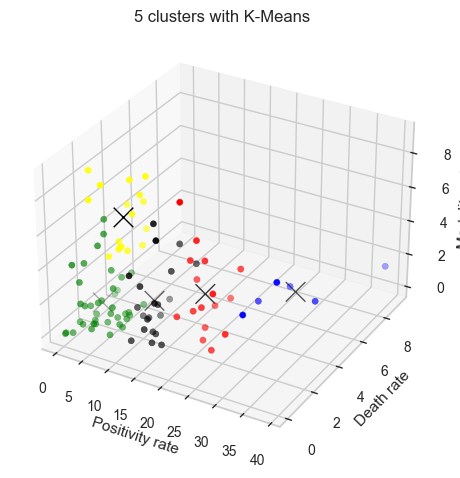

cluster 1 with: 16 entities (red)


,Latitude,Longitude,Average temperature per year,Hospital beds per 1000 people,Medical doctors per 1000 people,GDP/Capita,Population,Median age,Population aged 65 and over (%),"(Daily tests, min)","(Daily tests, max)","(Daily tests, mean)","(Daily cases, min)","(Daily cases, max)","(Daily cases, mean)","(Daily deaths, min)","(Daily deaths, max)","(Daily deaths, mean)",positivity_rate,death_rate,mortality_rate
Entity,,,,,,,,,,,,,,,,,,,,,
Albania,41.15,20.17,14.0,2.89,1.29,5353.2,2873457.0,38.0,14.0,1.0,4562.0,1192.831956,0.0,2077.0,287.363636,0.0,27.0,4.782369,24.090873,1.664222,3.630227
Bosnia and Herzegovina,43.92,17.68,12.0,3.50,1.89,6108.5,3507017.0,42.0,16.0,402.0,9431.0,2134.802469,0.0,2544.0,508.522634,0.0,86.0,19.629630,23.820594,3.860129,3.523536
Colombia,4.57,-74.30,25.0,1.71,1.82,6428.7,49065615.0,32.0,8.0,10885.0,93133.0,41124.195489,0.0,21078.0,8300.266917,0.0,400.0,219.364662,20.183415,2.642863,4.499834
Croatia,45.10,15.20,13.0,5.54,3.13,14936.1,4125700.0,44.0,20.0,8.0,12596.0,3746.563636,0.0,7088.0,733.596970,0.0,305.0,16.675758,19.580529,2.273150,5.867780
Dominican Republic,18.74,-70.16,26.0,1.60,1.49,8282.1,10766998.0,27.0,7.0,134.0,8674.0,2841.394366,0.0,5098.0,748.023474,0.0,67.0,12.446009,26.325929,1.663853,1.479790
Guatemala,15.78,-90.23,24.0,0.60,0.90,4620.0,16913503.0,22.0,5.0,1.0,8054.0,2437.418539,0.0,1739.0,469.932584,0.0,61.0,17.587079,19.279930,3.742468,0.989127
Indonesia,-0.79,113.92,26.0,1.04,0.20,4135.6,263991379.0,29.0,6.0,25.0,87194.0,21015.600746,0.0,37526.0,4164.462687,0.0,823.0,115.503731,19.816053,2.773557,0.422770
Iran,32.43,53.69,20.0,1.50,1.49,5550.1,81162788.0,32.0,6.0,9135.0,92186.0,28202.165680,0.0,38890.0,5908.467456,0.0,1489.0,252.118343,20.950403,4.267068,1.230282
Libya,26.34,17.23,24.0,3.70,2.09,7685.9,6374616.0,29.0,4.0,1.0,7698.0,2074.682143,0.0,1698.0,356.446429,0.0,48.0,6.160714,17.180773,1.728370,1.565663


cluster 1 with: 16 entities (red)


,Latitude,Longitude,Average temperature per year,Hospital beds per 1000 people,Medical doctors per 1000 people,GDP/Capita,Population,Median age,Population aged 65 and over (%),"(Daily tests, min)","(Daily tests, max)","(Daily tests, mean)","(Daily cases, min)","(Daily cases, max)","(Daily cases, mean)","(Daily deaths, min)","(Daily deaths, max)","(Daily deaths, mean)",positivity_rate,death_rate,mortality_rate
min,-30.56,-90.230000,9.0,0.20000,0.07000,523.40000,2873457.0,19.000,3.0000,1.0000,984.0000,329.213115,0.0,429.0,76.819672,0.0,10.0000,1.409836,17.012790,1.663853,0.019792
mean,17.77,-1.676875,20.0,2.75125,1.46875,6987.60625,38700387.0,31.125,9.0625,1930.5625,52418.0625,11944.292555,0.0,13521.0,2317.667776,0.0,350.6875,66.350085,20.519757,2.525135,2.677685
max,51.92,113.920000,29.0,8.80000,3.13000,15731.00000,263991379.0,44.000,20.0000,10885.0000,327863.0000,41124.195489,0.0,38890.0,8300.266917,0.0,1489.0000,252.118343,26.325929,4.267068,8.280463


cluster 2 with: 39 entities (green)


,Latitude,Longitude,Average temperature per year,Hospital beds per 1000 people,Medical doctors per 1000 people,GDP/Capita,Population,Median age,Population aged 65 and over (%),"(Daily tests, min)","(Daily tests, max)","(Daily tests, mean)","(Daily cases, min)","(Daily cases, max)","(Daily cases, mean)","(Daily deaths, min)","(Daily deaths, max)","(Daily deaths, mean)",positivity_rate,death_rate,mortality_rate
Entity,,,,,,,,,,,,,,,,,,,,,
Australia,-25.27,133.78,22.0,3.84,3.50,55060.3,2.459893e+07,37.0,16.0,4357.0,101274.0,41312.128319,0.0,1600.0,102.477876,0.0,74.0,3.845133,0.248058,3.752159,0.094150
Austria,47.52,14.55,8.0,7.37,5.23,50137.7,8.809212e+06,44.0,19.0,2376.0,2945871.0,43504.984756,0.0,9586.0,1346.457317,0.0,218.0,25.411585,3.094950,1.887292,5.013366
Bhutan,27.51,90.43,13.0,1.70,0.38,3316.2,8.076100e+05,28.0,6.0,2.0,15058.0,1587.459375,0.0,57.0,2.512500,0.0,1.0,0.003125,0.158272,0.124378,0.099553
Canada,56.13,-106.35,-1.0,2.50,2.54,46194.7,3.670808e+07,41.0,17.0,2568.0,255537.0,54156.436137,0.0,16141.0,2425.183801,0.0,244.0,62.102804,4.478108,2.560746,2.120743
Cuba,21.52,-77.78,26.0,5.20,7.52,8821.8,1.148464e+07,43.0,15.0,107.0,19710.0,6893.926254,0.0,1044.0,138.218289,0.0,6.0,0.905605,2.004928,0.655199,0.407989
Cyprus,35.13,33.43,20.0,3.40,2.50,27858.4,1.179551e+06,37.0,14.0,400.0,40974.0,6479.961078,0.0,907.0,100.883234,0.0,8.0,0.676647,1.556849,0.670723,2.856595
Denmark,56.26,9.50,8.0,2.50,3.66,60170.3,5.769603e+06,42.0,20.0,1.0,166497.0,43638.315508,0.0,4508.0,562.486631,0.0,60.0,6.288770,1.288974,1.118030,3.646178
El Salvador,13.79,-88.90,25.0,1.30,1.60,4187.3,6.377853e+06,27.0,8.0,457.0,5498.0,2321.788732,0.0,2015.0,183.061033,0.0,49.0,5.201878,7.884483,2.841609,0.611366
Ethiopia,9.14,40.49,24.0,0.30,0.02,855.8,1.049574e+08,19.0,4.0,61.0,25158.0,6347.771772,0.0,1829.0,468.735736,0.0,28.0,6.969970,7.384256,1.486972,0.148716


cluster 2 with: 39 entities (green)


,Latitude,Longitude,Average temperature per year,Hospital beds per 1000 people,Medical doctors per 1000 people,GDP/Capita,Population,Median age,Population aged 65 and over (%),"(Daily tests, min)","(Daily tests, max)","(Daily tests, mean)","(Daily cases, min)","(Daily cases, max)","(Daily cases, mean)","(Daily deaths, min)","(Daily deaths, max)","(Daily deaths, mean)",positivity_rate,death_rate,mortality_rate
min,-40.900000,-106.350000,-2.000000,0.300000,0.020000,679.300000,3.412840e+05,16.000000,1.000000,1.000000,6.370000e+02,90.672862,0.0,5.000000,0.208178,0.0,1.000000,0.003125,0.150289,0.082679,0.006184
mean,23.865385,45.743333,17.230769,3.452308,2.317179,20762.433333,6.702688e+07,33.230769,10.923077,581.769231,2.035205e+05,41882.011941,0.0,9903.461538,1783.402263,0.0,220.846154,29.063824,3.598307,1.501896,1.271740
max,64.960000,179.410000,29.000000,13.050000,7.520000,75419.600000,1.339180e+09,48.000000,28.000000,7533.000000,2.945871e+06,639512.728125,0.0,108201.000000,34142.237500,0.0,3410.000000,486.903125,7.884483,3.752159,5.529044


cluster 3 with: 6 entities (blue)


,Latitude,Longitude,Average temperature per year,Hospital beds per 1000 people,Medical doctors per 1000 people,GDP/Capita,Population,Median age,Population aged 65 and over (%),"(Daily tests, min)","(Daily tests, max)","(Daily tests, mean)","(Daily cases, min)","(Daily cases, max)","(Daily cases, mean)","(Daily deaths, min)","(Daily deaths, max)","(Daily deaths, mean)",positivity_rate,death_rate,mortality_rate
Entity,,,,,,,,,,,,,,,,,,,,,
Argentina,-38.42,-63.62,14.0,5.00,3.91,9912.3,44271041.0,31.0,11.0,1.0,48659.0,15414.997468,0.0,18326.0,5189.711392,0.0,3351.0,129.149367,33.666638,2.488565,4.630422
Bolivia,-16.29,-63.59,20.0,1.10,0.47,3552.1,11051600.0,25.0,7.0,1.0,9377.0,2153.768987,0.0,2866.0,769.468354,0.0,1656.0,35.750000,35.726596,4.646065,2.200152
Costa Rica,9.75,-83.75,26.0,1.13,1.15,12243.8,4905769.0,33.0,10.0,1.0,4648.0,1597.744745,0.0,1665.0,487.042042,0.0,33.0,6.195195,30.483095,1.272004,3.306006
Ecuador,-1.83,-78.18,22.0,1.50,1.66,6183.8,16624858.0,28.0,7.0,64.0,12181.0,2778.088415,0.0,3942.0,789.887195,0.0,3852.0,45.945122,28.432759,5.816669,1.558407
Mexico,23.63,-102.55,22.0,1.38,2.23,9946.0,129163276.0,29.0,7.0,25.0,46498.0,12138.567089,0.0,26626.0,4711.868354,0.0,3050.0,431.172152,38.817336,9.150768,1.440958
Peru,-9.19,-75.02,19.0,1.60,1.12,6977.7,32165485.0,29.0,8.0,74.0,37478.0,9086.830709,0.0,15792.0,2467.791339,0.0,3887.0,94.881890,27.157888,3.844810,1.948732


cluster 3 with: 6 entities (blue)


,Latitude,Longitude,Average temperature per year,Hospital beds per 1000 people,Medical doctors per 1000 people,GDP/Capita,Population,Median age,Population aged 65 and over (%),"(Daily tests, min)","(Daily tests, max)","(Daily tests, mean)","(Daily cases, min)","(Daily cases, max)","(Daily cases, mean)","(Daily deaths, min)","(Daily deaths, max)","(Daily deaths, mean)",positivity_rate,death_rate,mortality_rate
min,-38.420000,-102.550,14.0,1.100000,0.470000,3552.10,4.905769e+06,25.000000,7.000000,1.000000,4648.0,1597.744745,0.0,1665.000000,487.042042,0.0,33.000000,6.195195,27.157888,1.272004,1.440958
mean,-5.391667,-77.785,20.5,1.951667,1.756667,8135.95,3.969700e+07,29.166667,8.333333,27.666667,26473.5,7194.999569,0.0,11536.166667,2402.628113,0.0,2638.166667,123.848954,32.380719,4.536480,2.514113
max,23.630000,-63.590,26.0,5.000000,3.910000,12243.80,1.291633e+08,33.000000,11.000000,74.000000,48659.0,15414.997468,0.0,26626.000000,5189.711392,0.0,3887.000000,431.172152,38.817336,9.150768,4.630422


cluster 4 with: 17 entities (yellow)


,Latitude,Longitude,Average temperature per year,Hospital beds per 1000 people,Medical doctors per 1000 people,GDP/Capita,Population,Median age,Population aged 65 and over (%),"(Daily tests, min)","(Daily tests, max)","(Daily tests, mean)","(Daily cases, min)","(Daily cases, max)","(Daily cases, mean)","(Daily deaths, min)","(Daily deaths, max)","(Daily deaths, mean)",positivity_rate,death_rate,mortality_rate
Entity,,,,,,,,,,,,,,,,,,,,,
Bahrain,25.93,50.64,27.0,2.00,0.92,23504.0,1492584.0,32.0,2.0,232.0,23177.0,9254.615108,0.0,5114.0,435.312950,0.0,24.0,1.589928,4.703739,0.365238,8.107885
Belgium,50.50,4.47,10.0,5.64,3.01,46420.7,11372068.0,41.0,19.0,82.0,80815.0,25879.390582,0.0,23921.0,2107.498615,0.0,496.0,60.908587,8.143540,2.890089,6.690138
Chile,-35.68,-71.54,9.0,2.11,1.03,14896.5,18054726.0,35.0,12.0,2759.0,68458.0,28369.472050,0.0,13990.0,2502.015528,0.0,1057.0,62.872671,8.819394,2.512881,4.462261
Estonia,58.60,25.01,6.0,4.69,3.43,23723.3,1315480.0,42.0,20.0,8.0,8516.0,2517.841096,0.0,1152.0,168.838356,0.0,13.0,1.553425,6.705680,0.920066,4.684678
France,46.23,2.21,13.0,5.98,3.24,40493.9,67118648.0,42.0,20.0,6512.0,739281.0,181674.310954,0.0,106091.0,11934.374558,0.0,1279.0,200.992933,6.569104,1.684151,5.032026
Ireland,53.41,-8.24,9.0,2.96,2.96,78661.0,4813608.0,38.0,14.0,946.0,29972.0,10115.369186,0.0,8227.0,630.584302,0.0,220.0,12.406977,6.233923,1.967537,4.506412
Israel,31.05,34.85,21.0,2.99,3.58,43592.1,8712400.0,30.0,12.0,13.0,126326.0,34551.317204,0.0,11934.0,2063.779570,0.0,101.0,15.287634,5.973085,0.740759,8.811877
Italy,41.87,12.57,14.0,3.18,4.02,33228.2,60551416.0,47.0,23.0,964.0,353704.0,107296.715847,0.0,40902.0,7786.557377,0.0,993.0,263.062842,7.257032,3.378423,4.706546
Latvia,56.88,24.60,7.0,5.57,3.21,17828.9,1940740.0,43.0,20.0,10.0,13946.0,3931.271978,0.0,1861.0,233.469780,0.0,44.0,4.398352,5.938785,1.883906,4.378897


cluster 4 with: 17 entities (yellow)


,Latitude,Longitude,Average temperature per year,Hospital beds per 1000 people,Medical doctors per 1000 people,GDP/Capita,Population,Median age,Population aged 65 and over (%),"(Daily tests, min)","(Daily tests, max)","(Daily tests, mean)","(Daily cases, min)","(Daily cases, max)","(Daily cases, mean)","(Daily deaths, min)","(Daily deaths, max)","(Daily deaths, mean)",positivity_rate,death_rate,mortality_rate
min,-35.680000,-95.710000,4.000000,1.200000,0.920000,14896.500000,5.994490e+05,30.000000,1.000000,1.000000,8.516000e+03,2517.841096,0.0,1152.000000,151.108033,0.0,7.000000,0.760355,2.608260,0.159684,4.378897
mean,41.016471,4.825294,12.294118,3.694706,3.028824,42775.535294,3.503575e+07,39.529412,16.058824,1852.941176,2.762359e+05,96228.244203,0.0,37151.823529,7349.972432,0.0,670.058824,145.784036,7.439730,1.731009,6.468769
max,60.130000,51.180000,28.000000,6.560000,4.430000,114704.600000,3.257192e+08,47.000000,23.000000,11896.000000,2.238400e+06,912236.261111,0.0,299786.000000,78504.341667,0.0,4398.000000,1396.327778,10.957978,3.378423,9.100024


cluster 5 with: 21 entities (black)


,Latitude,Longitude,Average temperature per year,Hospital beds per 1000 people,Medical doctors per 1000 people,GDP/Capita,Population,Median age,Population aged 65 and over (%),"(Daily tests, min)","(Daily tests, max)","(Daily tests, mean)","(Daily cases, min)","(Daily cases, max)","(Daily cases, mean)","(Daily deaths, min)","(Daily deaths, max)","(Daily deaths, mean)",positivity_rate,death_rate,mortality_rate
Entity,,,,,,,,,,,,,,,,,,,,,
Bangladesh,23.68,90.36,25.0,0.80,0.47,1855.7,164669751.0,27.0,5.0,3.0,19054.0,11174.041899,0.0,4019.0,1522.217877,0.0,64.0,23.418994,13.622804,1.538478,0.330938
Bulgaria,42.73,25.49,13.0,7.45,4.00,9828.1,7075991.0,44.0,21.0,295.0,15651.0,5632.987952,0.0,5951.0,874.931727,0.0,292.0,33.606426,15.532285,3.841034,3.078834
Cape Verde,16.00,-24.01,24.0,2.10,0.79,3603.8,546388.0,25.0,5.0,50.0,980.0,397.805668,0.0,309.0,59.825911,0.0,4.0,0.574899,15.038979,0.960953,2.704488
Ghana,7.95,-1.02,27.0,0.90,0.10,2202.1,28833629.0,21.0,3.0,206.0,12735.0,2682.280899,0.0,2020.0,298.232210,0.0,28.0,2.134831,11.118605,0.715829,0.276164
Hungary,47.16,19.50,12.0,7.02,3.09,16731.8,9781127.0,43.0,19.0,39.0,32067.0,8842.595506,0.0,6819.0,1159.227528,0.0,193.0,41.297753,13.109584,3.562523,4.219197
Iraq,33.22,43.68,24.0,1.40,0.85,5955.1,38274618.0,20.0,3.0,698.0,53021.0,19739.054264,0.0,17988.0,2573.682171,0.0,441.0,50.031008,13.038528,1.943947,1.734857
Jamaica,18.11,-77.30,27.0,1.70,0.47,5582.3,2890299.0,31.0,9.0,34.0,1482.0,576.162162,0.0,1061.0,60.004505,0.0,17.0,1.360360,10.414517,2.267097,0.460887
Jordan,30.59,36.24,21.0,1.40,3.43,4405.5,9702353.0,23.0,4.0,9583.0,36073.0,22646.529915,0.0,7933.0,2629.581197,0.0,91.0,32.461538,11.611409,1.234476,3.170994
Kenya,-0.02,37.91,24.0,1.40,0.20,1816.5,49699862.0,20.0,2.0,21.0,19403.0,3224.626437,0.0,17081.0,399.304598,0.0,299.0,7.178161,12.382972,1.797665,0.139797


cluster 5 with: 21 entities (black)


,Latitude,Longitude,Average temperature per year,Hospital beds per 1000 people,Medical doctors per 1000 people,GDP/Capita,Population,Median age,Population aged 65 and over (%),"(Daily tests, min)","(Daily tests, max)","(Daily tests, mean)","(Daily cases, min)","(Daily cases, max)","(Daily cases, mean)","(Daily deaths, min)","(Daily deaths, max)","(Daily deaths, mean)",positivity_rate,death_rate,mortality_rate
min,-22.960000,-77.300000,8.00000,0.300000,0.020000,411.600000,5.463880e+05,17.000000,2.000000,1.000000,980.00000,308.108108,0.0,257.00000,32.416216,0.0,4.000000,0.574899,8.613165,0.556095,0.032204
mean,18.827143,21.012857,20.52381,2.466667,1.314762,9599.757143,3.284864e+07,27.619048,7.666667,658.142857,19893.52381,6935.056511,0.0,6677.47619,882.940710,0.0,164.666667,16.507663,12.554113,1.890141,1.955655
max,47.160000,90.360000,29.00000,7.450000,4.250000,81993.700000,1.908863e+08,44.000000,21.000000,9583.000000,60206.00000,22646.529915,0.0,23690.00000,2629.581197,0.0,830.000000,61.682310,15.532285,4.084622,6.542238


In [22]:
for k in range(2,6):
    kmeans = KMeans(n_clusters=k,n_init=10)
    label = kmeans.fit_predict(clusteringDf[['positivity_rate', 'death_rate', 'mortality_rate']])

    labels = kmeans.labels_
    colors = ['red', 'green', 'blue','yellow','black','magenda']
    resultDf = resultDf.copy()
    resultDf.loc[:, 'Graph_Color'] = [colors[label] for label in labels]
    ax = plt.axes(projection ='3d')
    ax.scatter(resultDf['positivity_rate'], resultDf['death_rate'], resultDf['mortality_rate'], c=resultDf['Graph_Color'])

    centroids = kmeans.cluster_centers_
    cluster_count=Counter(label)
    
    ax.scatter(centroids[:, 0], centroids[:, 1], centroids[:, 2], marker='x', s=200, linewidths=1, color='black')

    # Add labels to the plot
    ax.set_xlabel('Positivity rate')
    ax.set_ylabel('Death rate')
    ax.set_zlabel('Mortality rate')
    ax.set_title(f'{k} clusters with K-Means')

    # Show the plot
    plt.show()

    for i in range(k):
        print('cluster', i+1, 'with:', cluster_count[i], 'entities', '(' + str(colors[i]) + ')')
        clusterDf = df.groupby('Entity').describe()[kmeans.labels_==i].loc[:, (slice(None), ['min', 'max', 'mean'])]
        clusterDf2 = clusterDf.copy()
        df3 = clusteringDf[kmeans.labels_==i][['Entity', 'positivity_rate', 'death_rate', 'mortality_rate']].reset_index().drop('index', axis=1)
        df3= df3.set_index('Entity')
        clusterDf = clusterDf.drop(['Cases', 'Deaths', 'Daily tests', 'Daily cases', 'Daily deaths'], axis=1, level=0)
        displayDataframe = pd.concat([clusterDf.xs('mean', level=1, axis=1), clusterDf2[['Daily tests', 'Daily cases', 'Daily deaths']]], axis=1)
        displayDataframe = pd.concat([displayDataframe, df3[['positivity_rate', 'death_rate', 'mortality_rate']]], axis=1)
        display(displayDataframe) # if we want to display statistics for each country in the cluster
        print('cluster', i+1, 'with:', cluster_count[i], 'entities', '(' + str(colors[i]) + ')')
        display(displayDataframe.describe().loc[['min', 'mean', 'max']])